# Language Exploration Using Vector Space Models

Natural language processing is a huge sub-field of artificial intelligence that deals with models and representations for natural language.  A very common way to represent words, phrases, and documents in modern NLP involves the use of sparse vectors.  Here we'll explore a variety of Python libraries that implement various algorithoms related to natural language processing using vector space models.

The first thing we need is some text to work with.  NLTK (Natural Language Toolkit) has many popular corpora available for download directly from the API, so let's use that.  For this exercise we're going to use the Brown corpus.  Start by initiating the download tool and selecting the corpus.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import nltk
#nltk.download()

Check to make sure that the download was successful and we can access the data.

In [2]:
from nltk.corpus import reuters
len(reuters.words())

1720901

If you've never heard of the Reuters corpus, it's a collection of more than 10,000 news documents published in 1987 categorized into 90 different topics.  The content is obviously a bit dated but it's still interesting to work with because of the size of the collection and the fact that we have labeled topics for each document that we can use for certain types of supervised learning algorithms.  The corpus contains over 1.3 million words in total.

NLTK's feature set is focused more on the linguistic aspect of natural language processing than the machine learning aspect, with functions for tasks such as tokenization, stemming, tagging, and parsing.  Even so, there are some very useful functions we can take advantage of to get a sense of what's in this corpus.  Let's start by tabulating the number of unique words in the corpus. 

In [3]:
vocabulary = set(reuters.words())
len(vocabulary)

41600

There are 41,600 unique tokens in the corpus.  This doesn't tell us anything about the distribution of these tokens though.  NLTK has a built-in function to compute a frequency distribution for a text corpus.

In [4]:
fdist = nltk.FreqDist(reuters.words())
print(fdist)

<FreqDist with 41600 samples and 1720901 outcomes>


In [5]:
fdist.most_common(30)

[(u'.', 94687),
 (u',', 72360),
 (u'the', 58251),
 (u'of', 35979),
 (u'to', 34035),
 (u'in', 26478),
 (u'said', 25224),
 (u'and', 25043),
 (u'a', 23492),
 (u'mln', 18037),
 (u'vs', 14120),
 (u'-', 13705),
 (u'for', 12785),
 (u'dlrs', 11730),
 (u"'", 11272),
 (u'The', 10968),
 (u'000', 10277),
 (u'1', 9977),
 (u's', 9298),
 (u'pct', 9093),
 (u'it', 8842),
 (u';', 8762),
 (u'&', 8698),
 (u'lt', 8694),
 (u'on', 8556),
 (u'from', 7986),
 (u'cts', 7953),
 (u'is', 7580),
 (u'>', 7449),
 (u'that', 7377)]

We can plot these cumulatively to get a sense for how much of the corpus they represent.

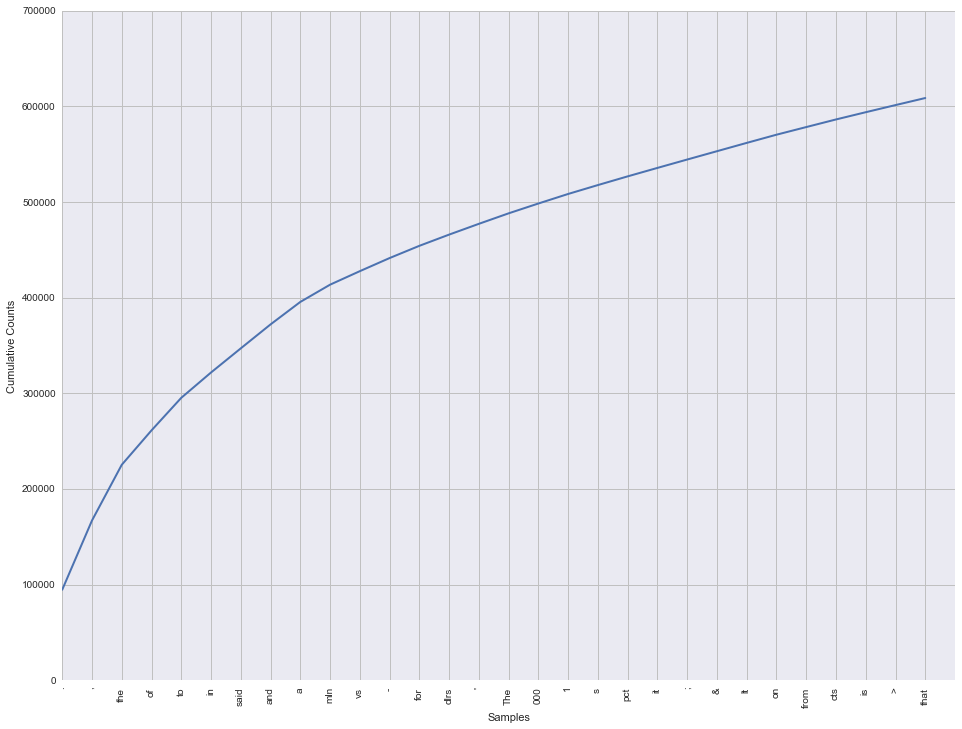

In [6]:
fig, ax = plt.subplots(figsize=(16,12))
ax = fdist.plot(30, cumulative=True)

Just 30 tokens make up around 35% of the entire corpus!  Moreover, most of these are things like punctuation and articles such as "and", "to", "of" and so on.  This is useful to know as we may want to strip out tokens like these.  You might also notice that the word 'the' appears on the list twice.  That's because the corpus contains both upper-case and lower-case words, and they are each counted separately.  Before we attempt to do anything with this data we'll need to correct these issues.

In [7]:
stopwords = nltk.corpus.stopwords.words()
cleansed_words = [w.lower() for w in reuters.words() if w.isalnum() and w.lower() not in stopwords]
vocabulary = set(cleansed_words)
len(vocabulary)

30618

After converting everything to lowercase, removing punctuation, and removing "stop words" using a pre-defined list of words that do not add any semantic value, we've reduced the vocabulary from almost 42,000 to just over 30,000.  Note that we still didn't address things like singular vs. plural being different words.  To handle this we'd have to get into topics like stemming, but for not let's leave as-is.  Let's look at the top 30 again.

In [8]:
fdist = nltk.FreqDist(cleansed_words)
fdist.most_common(30)

[(u'said', 25383),
 (u'mln', 18623),
 (u'vs', 14341),
 (u'dlrs', 12417),
 (u'000', 10277),
 (u'1', 9977),
 (u'pct', 9810),
 (u'lt', 8696),
 (u'cts', 8361),
 (u'year', 7529),
 (u'net', 6989),
 (u'2', 6528),
 (u'billion', 5829),
 (u'loss', 5124),
 (u'3', 5091),
 (u'5', 4683),
 (u'would', 4673),
 (u'company', 4670),
 (u'1986', 4392),
 (u'4', 4363),
 (u'shr', 4182),
 (u'inc', 4121),
 (u'bank', 3654),
 (u'7', 3450),
 (u'corp', 3399),
 (u'6', 3376),
 (u'oil', 3272),
 (u'last', 3243),
 (u'8', 3218),
 (u'share', 3160)]

The list is arguably a bit more interesting now.  There's a lot more that we could do with NLTK, but since we're interested in using this data to build statistical models, we need to find ways to "vectorize" this data.  One common way to represent text data is called the "bag of words" representation.  A bag of words represents each document in a corpus as a series of features that ask a question about the document.  Most commonly, the features are the collection of all distinct words the vocabulary of the entire corpus.  The values are usually either binary (representing the presence or absence of that word in the document) or a count of the number of times that word appears in the document.  A corpus is then represented as a matrix with one row per document and one column per unique word.

To build our initial bag of words matrix, we're going to use some of scikit-learn's built-in text processing capabilities.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
vectorizer

CountVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

We'll start off using scikit-learn's CountVectorizer class to transform our corpus into a sparse bag of words representation.  CountVectorizer expects as input a list of raw strings containing the documents in the corpus.  It takes care of the tokenization, transformation to lowercase, filtering stop words, building the vocabulary etc.  It also tabulates occurrance counts per document for each feature.

Since CountVectorizer expects the raw data as input rather than the pre-processed data we were working with in NLTK, we need to create a list of documents to pass to the vectorizer.

In [10]:
files = [f for f in reuters.fileids() if 'training' in f]
corpus = [reuters.raw(fileids=[f]) for f in files]
len(corpus)

7769

In [11]:
corpus[0]

u'BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.\n      The dry period means the temporao will be late this year.\n      Arrivals for the week ended February 22 were 155,221 bags\n  of 60 kilos making a cumulative total for the season of 5.93\n  mln against 5.81 at the same stage last year. Again it seems\n  that cocoa delivered earlier on consignment was included in the\n  arrivals figures.\n      Comissaria Smith said there is still some doubt as to how\n  much old crop cocoa is still available as harvesting has\n  practically come to an end. With total Bahia crop estimates\n  around 6.4 mln bags and sales standing at almost 6.2 mln there\n  are a few hundred thousand bags still in the hands of farmers,\n  middlemen, exporters and processors.\n 

Now we have the training corpus defined as a list of raw text documents.  We can pass this to our vectorizer to build our bag of words matrix.

In [12]:
X = vectorizer.fit_transform(corpus)
X

<7769x26001 sparse matrix of type '<type 'numpy.int64'>'
	with 426016 stored elements in Compressed Sparse Row format>

The vectorizer stores the data as a sparse matrix since a dense matrix would use way too much space and most of the values would be zero anyway (because each document only contains a small number of the total words in the vocabulary).  We can transform this to a numpy array if necessary though.

In [13]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int64)

The vectorizer stores the feature names (words) that map to the matrix column indexes.  We can inspect those if desired.  Note that I'm skipping to index 2000 because if you look at the beginning of the index, it's all numbers!  The reuters corpus, being news articles, contains quite a high volume of numeric symbols.  It's debatable wether or not we should really include these in the vocabulary, but for now they're there.

In [14]:
vectorizer.get_feature_names()[2000:2030]

[u'aero',
 u'aeroe',
 u'aerojet',
 u'aeronautics',
 u'aeroperu',
 u'aerosol',
 u'aerosols',
 u'aerospace',
 u'aerotech',
 u'aet',
 u'aetna',
 u'afbf',
 u'affadavit',
 u'affair',
 u'affairs',
 u'affandi',
 u'affect',
 u'affected',
 u'affecting',
 u'affects',
 u'affiliate',
 u'affiliated',
 u'affiliates',
 u'affiliation',
 u'affinerie',
 u'affirmation',
 u'affirmative',
 u'affirmed',
 u'afflicted',
 u'afford']

One potential issue with this representation is that it holds an in-memory mapping of the vocabulary to the document matrix that can get unwieldy on large datasets.  This approach also doesn't work when training in an on-line fashion since it needs to build the entire vocabulary ahead of time.  There's another vectorization algorithm implemented in scikit-learn that uses feature hashing to build the matrix in a stateless manner.  This HashingVectorizer class solves both of the above problems, however is comes with some tradeoffs - it's not possible to "inverse transform" the vector back to the original words, and there's a possibility of collisions that could cause some information to be lost.

In [15]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer()
X_hash = hv.transform(corpus)
X_hash

<7769x1048576 sparse matrix of type '<type 'numpy.float64'>'
	with 573305 stored elements in Compressed Sparse Row format>

For now we'll continue using the count vectorizer, but for very large corpora this approach would be faster and more efficient.

We now have a bag of words matrix, however there's another problem - some words appear much more frequently across the corpora as a whole than other words, so their presence in a document should carry less weight than a word that is very infrequent in general.  To adjust for this, we'll use something called TF-IDF weighting.  TF stands for term frequency, while IDF stands for inverse document frequency.  The TF-IDF calculation lowers the relative weight of common words and increases the relative weight of uncommon words.

Scikit-learn implements TF-IDF as a separate transform that we can apply to the output of our vectorizer.

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
tfidf

TfidfTransformer(norm=u'l2', smooth_idf=True, sublinear_tf=False,
         use_idf=True)

In [17]:
X_weighted = tfidf.fit_transform(X)
X_weighted.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.0802965 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.18269601,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Now that we have a weighted term-document matrix, let's do something with it.  A common natural language processing task is to classify documents as belonging to a particular category.  Since the reuters corpus is labeled, we can used a supervised learning algorithm to attempt to learn how to categorize similar news articles.

To do this we need a few additional pieces of information.  We need a set of labels, and we need a test set to evaluate performance of the model.  Forunately we have both available to us for the reuters dataset.

In [18]:
# build the term-document matrix for the test set using the existing transforms
test_files = [f for f in reuters.fileids() if 'test' in f]
test_corpus = [reuters.raw(fileids=[f]) for f in test_files]
X_test = vectorizer.transform(test_corpus)
X_test_weighted = tfidf.transform(X_test)

# get the categories for each document in both the train and test sets
train_labels = [reuters.categories(fileids=[f]) for f in files]
test_labels = [reuters.categories(fileids=[f]) for f in test_files]

Since there are 90 distinct categories, and each document can be assigned to more than one category, we probably don't have enough documents per category to build a really good document classifier.  We're going to simplify the problem a bit and reduce the classification to a binary problem - wether or not the document belongs to the 'acq' category.

In [19]:
y = np.asarray([1 if 'acq' in label else 0 for label in train_labels])
y_test = np.asarray([1 if 'acq' in label else 0 for label in test_labels])

In [20]:
X_weighted.shape, y.shape, X_test_weighted.shape, y_test.shape

((7769, 26001), (7769L,), (3019, 26001), (3019L,))

Now we're ready to train a classifier.  We'll use multinomial Naive Bayes in this example.

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# train the classifier
classifier = MultinomialNB()
classifier.fit(X_weighted, y)

# predict labels for the test set
predictions = classifier.predict(X_test_weighted)

# output the classification report
label_names = ['not acq', 'acq']
print(classification_report(y_test, predictions, target_names=label_names))

             precision    recall  f1-score   support

    not acq       0.87      1.00      0.93      2300
        acq       0.99      0.52      0.68       719

avg / total       0.90      0.88      0.87      3019



So that's a pretty reasonable outcome, although the recall is not as high as we would like it to be.  There are a number of ways we could work to improve this result, such as experimenting with removing extraenous tokens such as numbers from our vocabulary or constructing additional high-level features about the documents.  For a simple bag-of-words model though it's not too bad.

Supervised learning is nice when we have a labeled dataset, but the vast majority of text in the wild does not come with any sort of label so its usefulness in natural language processing is often limited.  What about unsupervised techniques to categorize documents?  Scikit-learn packages a decomposition technique called non-negative matrix factorization (NMF) that we can use for topic extraction.

In [22]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=10).fit(X_weighted)

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print('Topic #%d:' % topic_idx)
    print(' '.join([feature_names[i] for i in topic.argsort()[:-20 - 1:-1]]))
    print('')

Topic #0:
loss profit vs 000 cts dlrs oper shr revs year qtr 4th includes net discontinued note operations 1986 quarter excludes

Topic #1:
pct february january rose year rise rate index december prices 1986 inflation said fell compared growth consumer statistics base production

Topic #2:
cts qtly div record april pay prior vs dividend sets march quarterly lt payout 15 10 payable regular 30 31

Topic #3:
said trade japan dollar bank yen japanese exchange foreign rates market rate dealers economic currency paris countries nations government told

Topic #4:
vs mln 000 net cts shr revs qtr avg shrs oper dlrs note profit 4th lt year mths 31 sales

Topic #5:
billion dlrs surplus deficit mln francs marks 1986 january year rose february reserves trade fell 1985 account foreign december exports

Topic #6:
fed customer repurchase says reserves federal agreements funds reserve temporary sets dlrs week repurchases securities economists supply billion add trading

Topic #7:
stg mln bank money mar

The above output takes the components derived from the factorization (here assumed to model a "topic" from the corpus) and extracts the 20 words that most significantly contributed to that topic.  Although it's not perfect, we can see some commonalites among the groups of words.

NMF gives some interesting results, but there are more advanced algorithms for topic modeling.  Latent Dirichlet Allocation (LDA), for example, is a technique that models documents as though they are composed of some undefined number of topics.  Each of the words in the document are then said to be attributed to some combination of those topics.  

Scikit-learn does not implement LDA so if we want to try it out, we'll need to look elsewhere.  Fortunately there's a library called gensim that's focused specifically on topic modeling.  To start off we need our corpus in a format that gensim models can use as input.  Gensim implements a lot of the same transforms that we just applied to the data, but rather that re-create the same transforms we can re-use what we've already done and convert our term-document matrix into gensim's expected format.

In [23]:
from gensim import corpora, models, similarities, matutils

# create the corpus using a conversion utility
gensim_corpus = matutils.Sparse2Corpus(X_weighted)

# build the LDA model
lda = models.LdaModel(gensim_corpus, num_topics=100)
lda

With our LDA model we could now examine the words that most contribute to each topic (as we did with NMF), or we could compare new documents to the model to identify either the topics that make up that document or the existing documents that they are most similar to.  However, I want to move on from NMF/LDA to another algorithm implemented in gensim called word2vec because it's really, really interesting.  Word2vec is an unsupervised neural network model that runs on a corpus of text and learns vector representations for the individual words in the text.  The word vectors are modeled in a way such that words that are semantically "close" to each other are also close in a mathematical sense, and this results in some interested properties.  Let's explore some of the implications on the reuters dataset.

Since word2vec expects a list of sentences as input, we'll need to go back to the pre-transformed sentence list provided by NLTK.

In [24]:
model = models.Word2Vec(reuters.sents(), size=100, window=5, min_count=5, workers=4)

We now have a trained word2vec model.  It's possible to look at the vector for a word directly, although it won't mean much to a person.

In [25]:
model['market']

array([ 0.36218089,  0.04660718, -0.03312639, -0.00589092,  0.08425491,
       -0.05584015,  0.39824656, -0.19913128,  0.21185778, -0.16018888,
       -0.30720046,  0.41359827,  0.05477867,  0.40744004, -0.15048127,
       -0.21775401, -0.0918686 ,  0.08254269, -0.36109206, -0.08484149,
       -0.37724456,  0.19134018,  0.18765855,  0.17301551, -0.13106611,
        0.10278706,  0.14409529,  0.09305458, -0.27449781, -0.16971849,
        0.20959041,  0.12159102,  0.07963905,  0.03050068,  0.31353745,
        0.06859812, -0.26051152,  0.1805039 ,  0.28199297, -0.19140336,
        0.13152425,  0.04389969,  0.06004116, -0.31306067, -0.12013798,
       -0.17255786, -0.05460097, -0.35606486,  0.31404966,  0.03737779,
       -0.11519474,  0.31271645, -0.31853175,  0.08142728,  0.09033886,
       -0.15671426, -0.07798025,  0.06073617,  0.2294289 ,  0.13113637,
       -0.04398542, -0.34159404,  0.06506728,  0.20032322, -0.11604583,
       -0.14258914, -0.06725569, -0.06181487,  0.13476266,  0.17

Every word in the vocabulary now has a vector representation that looks like this.  Since we're dealing with vectors, it's possible to compare words using vector math such as the cosine similarity.

In [26]:
model.similarity('dollar', 'yen')

0.7455091131291105

In [27]:
model.similarity('dollar', 'potato')

0.28685558842610581

According to the model, 'dollar' and 'yen' are much more similar to each other (both being currencies) than 'dollar' and 'potato'.  The relationship is deeper than just a similarity measure though.  The word2vec model is capable of capturing abstract concepts as well.  The ubiquitous example is "woman + king - man = queen".  When properly trained on a large enough amount of text, the model is able to detect that the relationship between 'woman' and 'queen' is similar to the relationship between 'man' and 'king'.  Let's see if the model we just trained can do something similar.

In [28]:
model.most_similar(positive=['Japan', 'dollar'], negative=['US'])

[(u'appreciation', 0.6466031670570374),
 (u'appreciated', 0.596366822719574),
 (u'sterling', 0.5693594813346863),
 (u'Taiwan', 0.5512674450874329),
 (u'slowly', 0.5457212924957275),
 (u'mark', 0.5433770418167114),
 (u'yen', 0.5293248891830444),
 (u'stems', 0.5171161890029907),
 (u'pleas', 0.5137792825698853),
 (u'brake', 0.5080464482307434)]

It didn't get it exactly right, although 'yen' is on the list, but there's a lot of other noise too.  This is mostly likely due to the relatively small size of the dataset.  Word2vec needs a huge amount of training data to work really well.  Some parameter tuning might help too - for example, a size of 100 dimensions might be way too big for the amount of data in the reuters dataset.

Let's see if there's a way to visualize some of the information captured by the model.  Since the vectors are high-dimensional we can't visualize them directly, but we can apply a dimension reduction technique like PCA and use the first two principal components as coordinates.  We can try this with a group of words that should be somewhat similar, such as countries.

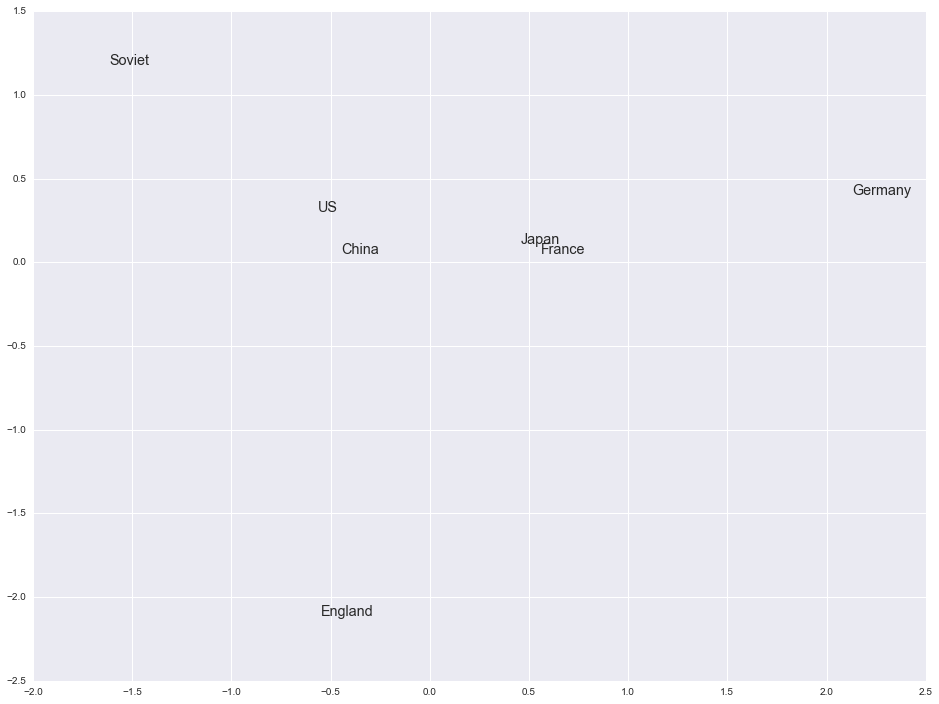

In [29]:
from sklearn.decomposition import PCA

words = ['US', 'China', 'Japan', 'England', 'France', 'Germany', 'Soviet']
word_vectors = [model[word] for word in words]

# create and apply PCA transform
pca = PCA(n_components=2)
principal_components = pca.fit_transform(word_vectors)

# slice the 2D array
x = principal_components[:, 0]
y = principal_components[:, 1]

# plot with text annotation
fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(x, y, s=0)

for i, label in enumerate(words):
    ax.annotate(label, (x[i], y[i]), size='x-large')

They're a bit more spread out than I thought they would be, but a few (such as U.S. and China) are very close.  These probably appeared frequently in the text so there may have been a larger amount of training data for these terms.  The results become more interesting when applied to very large datasets, and indeed Google and others have done just that.  In fact, applying this methodology to words is only the beginning.  It's already been extended or is being extended to phrases and even entire documents.  It's a very promising research area and I'm excited to see what comes out of it in the next few years.